# Goal:
This notebook is used to create a predictive model to see what college basketball player could be be drafted into the nba. The model will look at highschool rankings and college basketball stats to predict if this player could be an NBA player. We use this model to get a percentage that the player could get drafted and use that as a threshold for our second model. 

Note: We have issues with imblearn being installed in-line, so please run `pip install imblearn` in a terminal window and restart the kernel.

In [1]:
! pip install yellowbrick lifelines sportsreference
! pip install -e "git+https://github.com/perrygeo/jenks.git#egg=jenks"
import pandas as pd
import numpy as np
import getpass
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.externals import joblib as jb
from jenks import jenks
from yellowbrick.classifier import ROCAUC
from imblearn.over_sampling import SMOTE
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(14, 10)})

Obtaining jenks from git+https://github.com/perrygeo/jenks.git#egg=jenks
  Updating ./src/jenks clone
  Running command git fetch -q --tags
  Running command git reset --hard -q 80b2557d635ba4a0640157d3616b50dbf39c2221
  Found existing installation: jenks 1.0
    Uninstalling jenks-1.0:
      Successfully uninstalled jenks-1.0
  Running setup.py develop for jenks


/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


With having multiple models running over the same data sets we wanted to make sure when we train and test our data that both models are seeing the same training and testing data. This was in order to prevent the testing data of one model to be in the training data of the other. It will ensure clean uncompromised testing results. 

This was accomplished by sampling at the same point and using the same random state for each time we load in the data. 

In [2]:
df = pd.read_csv('../Data/historical_binned.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,ncaa_id,player_name,nba_career_quality,made_nba,field_goals_bin_1,field_goals_bin_2,field_goals_bin_3,field_goals_bin_4,three_point_attempt_rate_bin_1,three_point_attempt_rate_bin_2,three_point_attempt_rate_bin_3,defensive_win_shares_bin_1,defensive_win_shares_bin_2,defensive_win_shares_bin_3,defensive_win_shares_bin_4,blocks_bin_1,blocks_bin_2,blocks_bin_3,blocks_bin_4,blocks_bin_5,games_played_bin_1,games_played_bin_2,games_played_bin_3,turnovers_bin_1,turnovers_bin_2,turnovers_bin_3,turnovers_bin_4,turnover_percentage_bin_1,turnover_percentage_bin_2,turnover_percentage_bin_3,total_rebounds_bin_1,total_rebounds_bin_2,total_rebounds_bin_3,total_rebounds_bin_4,three_pointers_bin_1,three_pointers_bin_2,three_pointers_bin_3,three_pointers_bin_4,games_started_bin_1,games_started_bin_2,games_started_bin_3,games_started_bin_4,three_point_percentage_bin_1,three_point_percentage_bin_2,three_point_percentage_bin_3,three_point_percentage_bin_4,offensive_win_shares_bin_1,offensive_win_shares_bin_2,offensive_win_shares_bin_3,weight_bin_1,weight_bin_2,weight_bin_3,weight_bin_4,weight_bin_5,free_throw_percentage_bin_1,free_throw_percentage_bin_2,free_throw_percentage_bin_3,two_pointers_bin_1,two_pointers_bin_2,two_pointers_bin_3,two_pointers_bin_4,high_school_national_rank_bin_1,high_school_national_rank_bin_2,defensive_rebounds_bin_1,defensive_rebounds_bin_2,defensive_rebounds_bin_3,defensive_rebounds_bin_4,free_throw_attempts_bin_1,free_throw_attempts_bin_2,free_throw_attempts_bin_3,free_throw_attempts_bin_4,field_goal_percentage_bin_1,field_goal_percentage_bin_2,field_goal_percentage_bin_3,field_goal_percentage_bin_4,field_goal_percentage_bin_5,two_point_attempts_bin_1,two_point_attempts_bin_2,two_point_attempts_bin_3,two_point_attempts_bin_4,field_goal_attempts_bin_1,field_goal_attempts_bin_2,field_goal_attempts_bin_3,field_goal_attempts_bin_4,two_point_percentage_bin_1,two_point_percentage_bin_2,two_point_percentage_bin_3,two_point_percentage_bin_4,steals_bin_1,steals_bin_2,steals_bin_3,steals_bin_4,free_throw_attempt_rate_bin_1,free_throw_attempt_rate_bin_2,free_throw_attempt_rate_bin_3,free_throw_attempt_rate_bin_4,free_throw_attempt_rate_bin_5,free_throw_attempt_rate_bin_6,points_bin_1,points_bin_2,points_bin_3,points_bin_4,usage_percentage_bin_1,usage_percentage_bin_2,usage_percentage_bin_3,three_point_attempts_bin_1,three_point_attempts_bin_2,three_point_attempts_bin_3,three_point_attempts_bin_4,offensive_rebounds_bin_1,offensive_rebounds_bin_2,offensive_rebounds_bin_3,offensive_rebounds_bin_4,high_school_recruit_score_bin_2,high_school_recruit_score_bin_3,high_school_recruit_score_bin_4,high_school_recruit_score_bin_5,high_school_recruit_score_bin_6,draft_rank_bin_1,draft_rank_bin_2,draft_rank_bin_3,draft_rank_bin_4,draft_rank_bin_5,assists_bin_1,assists_bin_2,assists_bin_3,assists_bin_4,personal_fouls_bin_1,personal_fouls_bin_2,personal_fouls_bin_3,personal_fouls_bin_4,assist_percentage_bin_1,assist_percentage_bin_2,assist_percentage_bin_3,assist_percentage_bin_4,minutes_played_bin_1,minutes_played_bin_2,minutes_played_bin_3,minutes_played_bin_4,height_bin_1,height_bin_2,height_bin_3,height_bin_4,height_bin_5,made_nba_bin_1,made_nba_bin_2,height_to_weight_bin_1,height_to_weight_bin_2,height_to_weight_bin_3,height_to_weight_bin_4,height_to_weight_bin_6,weight_to_height_bin_1,weight_to_height_bin_2,weight_to_height_bin_3,weight_to_height_bin_4,weight_to_height_bin_5,weight_to_height_bin_6,recruit_draft_rank_mean_bin_1,recruit_draft_rank_mean_bin_2,draft_recruit_ratio_bin_1,draft_recruit_ratio_bin_2,draft_recruit_ratio_bin_3,draft_recruit_ratio_bin_4,assist_to_turnover_ratio_bin_1,assist_to_turnover_ratio_bin_2,assist_to_turnover_ratio_bin_3,assist_to_turnover_ratio_bin_4,assist_to_turnover_ratio_bin_5,assist_to_turnover_ratio_bin_6,assists_per_minute_bin_1,assists_per_minute_bin_2,assists_per_minute_bin_3,assists_per_minute_bin_4,assists_per_minute_bin_5,assists_per_minute_bin_6,blocks_per_minute_bin_1,blocks_per_minute_bin_2,bl

The next step is to get the model up and running. We want the model to run with the best parameters, so we have to set up a gridsearch to find those. We have a lot of features in our data set, so with that we use a select k best diminsion reducing function in our gridsearch to find the optimal amount of features used in our model. Next, we are using a LogisticRegression model as our estimator. This was after experimenting various models such as RandomForest and SVC but settled on a Logistic Regression model which balanced computational efficiency and model accuracy. We then looked at several different parameters to see which will give us the best results for our Logistic Regression. 

We put all of that into our grid search, and we run it with 5 cross validations and our scoring based on the roc auc score. We wanted to look at roc auc score because the ratio of true positives and false positivies is an important measure for when predicting if players will make the NBA. We want to be sure our model is correctly predicting NBA players and not just saying everyone is not an NBA player. 

In [4]:
pipe = Pipeline([
    ('reduce_dim', SelectKBest()),
    ('estimator', LogisticRegression())
])

In [ ]:
param_grid = [
    {
        'reduce_dim__score_func': [f_classif, mutual_info_classif],
        'reduce_dim__k' : [3, 5, 10, 25, 50, 75, 100, 150, 200, 'all'],
        'estimator__penalty' : ['l1', 'l2'],
        'estimator__C' : [0.01, 0.1, 1, 10, 100],
        'estimator__class_weight' : ['balanced', None],
        'estimator__fit_intercept' : [True, False],
        'estimator__max_iter' : [50, 100, 250, 500, 1000, 2500],
        'estimator__multi_class' : ['auto', 'ovr']
    }
]

In [ ]:
grid = GridSearchCV(pipe, cv = 5, param_grid = param_grid, scoring = 'roc_auc', verbose = 2)

The gridsearch is commented so we can run our notebook multiple times without refitting the gridsearch. Please uncomment if needed to run the gridsearch.

In [ ]:
#grid.fit(x, y)

In [5]:
x = np.array(df.drop(['made_nba', 'ncaa_id', 'player_name', 'nba_career_quality'], axis = 1))
y = np.array(df.made_nba)

From our grid search we get the parameters used in our models below.

In [6]:
kb = SelectKBest(f_classif, k = 10)
kb.fit(x, y)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 23  24  25  98  99 100 127 128 129 130 140 141 157 158 253 367] are constant.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


SelectKBest(k=10, score_func=<function f_classif at 0x7ffa936e2c80>)

In [7]:
final_features = df.columns[[kb.get_support(True)]].to_list()
final_features

/opt/conda/lib/python3.7/site-packages/pandas/core/indexes/base.py:4291: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


['offensive_rebounds_bin_4',
 'high_school_recruit_score_bin_3',
 'high_school_recruit_score_bin_4',
 'draft_rank_bin_1',
 'height_bin_2',
 'height_bin_3',
 'win_shares_per_minute_bin_4',
 'usage_percentage',
 'personal_fouls',
 'height']

In [8]:
kb_x = kb.fit_transform(x, y)

/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 23  24  25  98  99 100 127 128 129 130 140 141 157 158 253 367] are constant.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Here we load our LogisticRegression with the optimal hyper parameters. We tuned C which is the inverse of regularization strength to the value of 10 which is 10x larger than the default value. Thus, we are decreasing regularization in order to maximize the prediction accuracy of our limited NBA data since our non-nba players population far outweighs our nba player population.  

In [9]:
reg = LogisticRegression(C = 10, max_iter = 2500)
x_train, x_test, y_train, y_test = train_test_split(kb_x, y, random_state = 1)

To produce our final training set of data we use a package call SMOTE. This used to over sample our training data. The amount of data we have from college players who do not make the NBA drowns out the data from the players that do make the NBA. The oversampling will create fake data to boost the amount of NBA player data we do have to make the training data more balanced. This will help the model we create to not only predict that a player would not make the NBA. 

In [10]:
sm = SMOTE()
x_rs, y_rs = sm.fit_resample(x_train, y_train)

In [11]:
reg.fit(x_rs, y_rs)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
y_pred = [x[1] for x in reg.predict_proba(x_test)]

Let's check our distribution for the NBA draft predictions. This distribution makes sense as we expect the majority of our players would not get drafted into the NBA.

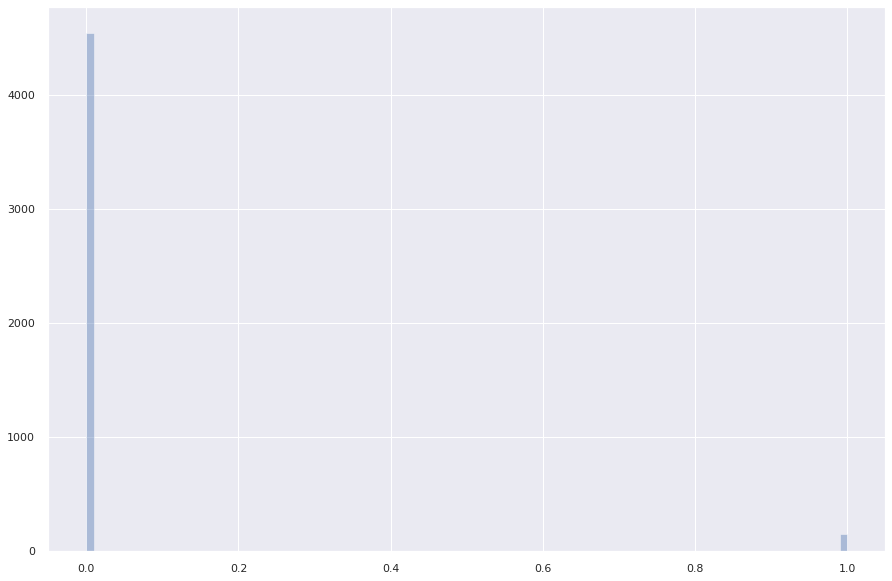

In [13]:
sns.set(rc = {'figure.figsize':(15, 10)})
sns.distplot(y_pred,
            bins = 100,
            kde = False);

In [14]:
df['nba_pred'] = [x[1] for x in reg.predict_proba(kb_x)]

Finally we pickel our model to be used in later steps.

In [20]:
jb.dump(kb, '../Models/nba_model_kbest.pkl')
jb.dump(reg, '../Modelsnba_model.pkl')

['nba_model.pkl']